In [1]:
# Copyright 2019 The TensorFlow Authors.

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 9_Saving and Loading Models

In this tutorial we will learn how we can take a trained model, save it, and then load it back to keep training it or use it to perform inference. 
- In particular, we will use transfer learning to train a classifier to classify images of cats and dogs, just like we did in the previous lesson. 
- We will then take our trained model and save it as an HDF5 file, which is the format used by Keras. 
- We will then load this model, use it to perform predictions, and then continue to train the model. 
- Finally, we will save our trained model as a TensorFlow SavedModel and then we will download it to a local disk, so that it can later be used for deployment in different platforms.

#### Concepts that will be covered in this Colab
1. Saving models in HDF5 format for Keras
2. Saving models in the TensorFlow SavedModel format
3. Loading models
4. Download models to Local Disk

#### Imports

In [2]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

In [3]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
     
import os

#### Load Dataset

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
     
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [6]:
BATCH_SIZE = 32
IMAGE_RES = 224

In [7]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_RES,IMAGE_RES),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [8]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMAGE_RES, IMAGE_RES),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


#### Transfer Learning with TensorFlow Hub

In [9]:
#Define tensorflow hub layer
mobilenet_v2 = tf.keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(IMAGE_RES, IMAGE_RES, 3)
)
mobilenet_v2.trainable = False  # Freeze the pre-trained weights

#Build our layers
inputs = tf.keras.Input(shape=(IMAGE_RES, IMAGE_RES, 3))
x = mobilenet_v2(inputs)

#change tensorflow output into vectors
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#add classification layer
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

#build model from layers
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Train the model

In [11]:
#compile
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [12]:
EPOCHS = 3

history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)

Epoch 1/3


c:\Users\ih371\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 513ms/step - accuracy: 0.8021 - loss: 0.3906 - val_accuracy: 0.9710 - val_loss: 0.0822
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 339ms/step - accuracy: 0.9463 - loss: 0.1241 - val_accuracy: 0.9770 - val_loss: 0.0619
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step - accuracy: 0.9584 - loss: 0.1197 - val_accuracy: 0.9800 - val_loss: 0.0586


#### Check Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
[9.999577e-01 4.226607e-05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[2.820077e-04 9.997180e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0.00723458 0.9927654 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[1.1835121e-04 9.9988163e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0.04392092 0.95607907]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.24276529 0.7572347 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.0137052 0.9862948]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0.99817145 0.00182855]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[9.9978775e-01 2.1228229e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[3.9221713e-04 9.9960786e-01]


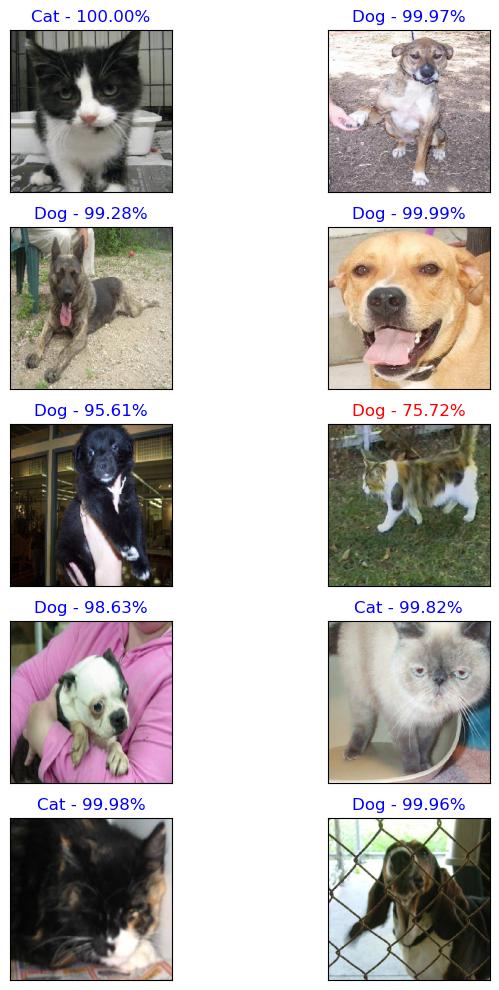

In [13]:
# Get a batch of data
data, labels = next(val_data_gen)

num_images = 10  # Number of images to display
plt.figure(figsize=(8, 10))
# Loop through the first 10 images in the batch
for i in range(min(num_images, len(data))):
  current_image = data[i]
  current_label = labels[i]

  # Make prediction on the current image
  predictions = model.predict(np.expand_dims(current_image, axis=0))

  # Decode the one-hot encoded label and get confidence
  class_names = ['Cat', 'Dog']
  predicted_class = np.argmax(predictions[0])
  predicted_label_text = class_names[predicted_class]
  color = 'blue' if current_label == predicted_class else 'red'
  confidence = np.max(predictions[0]) * 100  # Convert confidence to percentage
  print(predictions[0])
  # Rescale the image data to a range of 0-1 for visualization
  if np.max(current_image) > 1:
    current_image = current_image / 255.0

  # Create a subplot and display the image with label and confidence
  plt.subplot(5, 2, i + 1)  # Arrange images in a 5x2 grid
  plt.imshow(current_image)
  plt.title(f"{predicted_label_text} - {confidence:.2f}%", color=color)  # Display label and confidence
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)  # Remove grid lines for better visualization

# Ensure the plot is displayed even if less than 10 images are available
plt.tight_layout()
plt.show()

#### Export as SavedModel

In [97]:
model.save('my_model.keras') 

In [98]:
loaded_model = tf.keras.models.load_model('my_model.keras', custom_objects={'KerasLayer': hub.KerasLayer})


c:\Users\ih371\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 160 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
[0.9797249  0.02027513]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.00695178 0.9930482 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.01791531 0.9820847 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[9.9989414e-01 1.0589799e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.00414062 0.99585944]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.14592399 0.85407597]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[0.00133285 0.9986671 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.9974808  0.00251919]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.00280431 0.9971957 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.989884   0.01011592]


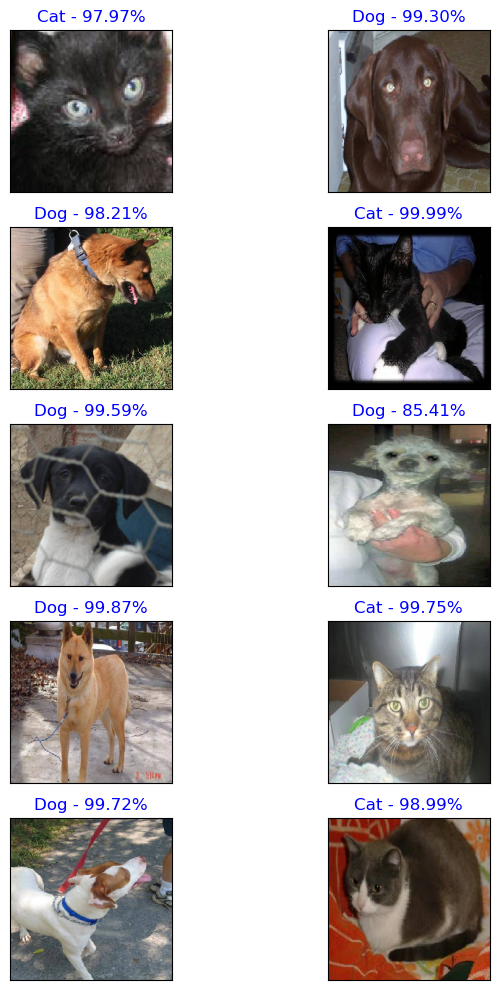

In [99]:
# Get a batch of data
data, labels = next(val_data_gen)

num_images = 10  # Number of images to display
plt.figure(figsize=(8, 10))
# Loop through the first 10 images in the batch
for i in range(min(num_images, len(data))):
  current_image = data[i]
  current_label = labels[i]

  # Make prediction on the current image
  predictions = loaded_model.predict(np.expand_dims(current_image, axis=0))

  # Decode the one-hot encoded label and get confidence
  class_names = ['Cat', 'Dog']
  predicted_class = np.argmax(predictions[0])
  predicted_label_text = class_names[predicted_class]
  color = 'blue' if current_label == predicted_class else 'red'
  confidence = np.max(predictions[0]) * 100  # Convert confidence to percentage
  print(predictions[0])
  # Rescale the image data to a range of 0-1 for visualization
  if np.max(current_image) > 1:
    current_image = current_image / 255.0

  # Create a subplot and display the image with label and confidence
  plt.subplot(5, 2, i + 1)  # Arrange images in a 5x2 grid
  plt.imshow(current_image)
  plt.title(f"{predicted_label_text} - {confidence:.2f}%", color=color)  # Display label and confidence
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)  # Remove grid lines for better visualization

# Ensure the plot is displayed even if less than 10 images are available
plt.tight_layout()
plt.show()